# Project discrete optimization: a walk to the park

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

Daan Van Hauwermeiren, Bram De Jaegher

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

In this project we will study a fictitious city (you can imagine it to be the capital of your favourite fantasy setting). A map of this city is given below.

![A city with streets and parks.](Figures/city_map.png)

Every point on this map is a crossing, and every grey line is a street between two crossings. Every street is a straight line and the length of the street is just the Euclidean distance between the two crossings.

This city also has some parks, indicated in green:

- **park A** at the top left corner;
- **park B** on the right, traversing top to bottom;
- **park C**, the little circular region in the middle.

This city can be represented as a weighted graph. Every vertex has an integer identifier and is associated with an $x,y$ coordinate. We have also three lists containing the indices of the vertices lying in the parks.

In [2]:
with open('Data/city.json', 'r') as fh:
    city = json.load(fh)
    
edges = list(map(tuple, city['edges']))
coordinates = city['coordinates']
vertices = list(city['vertices'])

park_A = city['parks']['A']
park_B = city['parks']['B']
park_C = city['parks']['C']

The main research question of this project is:

> What is the shortest path from *any* vertex to a vertex in a park?

As a first heuristic, we can use the minimum spanning tree on the graph. As seen in the theory, this is the tree tree that connects all vertices and has the lowest cost. From this tree, there is a single path from every edge to every other edge.

In a second step, we will use shortest path algorithms to find the true shortest path for every vertex.

**ASSIGNMENTS**

1. Find the minimum spanning tree for this graph.
    - Make a plot of the minimum spanning tree for this graph.
    - Compute the distance from any vertex on the minimum spanning tree to the closest vertex lying in a park.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).
2. Compute the shortest distances from any vertex to the closest vertex (note that all shortest paths together will be a forest).
    - Implement this in an efficient way, **not** by using A* in a for-loop!
    - Show your solution on a plot, color the vertices according to the distances to the closest park and add arrows to indicate which vertex to take.
    - Show for every vertex whether park A, B or C is the closest.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park). Compare with the minimum spanning tree.

Some guidelines for completing this project:

- Write clear code with human-readable names and comments where needed. Add a (basic) docstring to all your functions.
- Make clear figures with ax labels, titles etc.
- Always provide some interpretation of the results.
- You **can** recycle and modify code from earlier chapters or other sources. Clearly indicate where you obtained this code from (you can add a hyperlink to the original source).

Finally, some hints that can help you do this project efficiently:

- Carefully read all assignments, assignment 1 and 2 essentially ask the same thing.
- The shortest path from vertex A to vertex B is the same as from vertex B to vertex A.
- If vertex C is on the shortest path from vertex A to vertex B, then you also found the shortest path from vertex C to vertex B. 

## General functions definitions & loading libraries (from previous lessons)

In [3]:
import heapq
from functools import reduce
import operator
import itertools

Prims algorithm, implemented in course

In [4]:
def prim(vertices, edges, start, add_weights=False):
    """
    Prim's algorithm for finding a minimum spanning tree.

    Inputs :
        - vertices : a set of the vertices of the Graph
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)
        - start : an edge to start with

    Output:
        - edges : a minumum spanning tree represented as a list of edges
        - total_cost : total cost of the tree
    """
    adj_list = edges_to_adj_list(edges)
    # list of tuples describing the edges starting from the start
    # vertix, with weights, i.e. the candidate edges
    to_check = [(w, start, v_new) for w, v_new in adj_list[start]]
    # heapify the list (~sorting)
    heapq.heapify(to_check)
    # for every node connected to the
    #dist_to_mst = {i : (w, start) for w, i in adj_list.pop(start)}
    mst_edges = []
    mst_vertices = set([start])
    total_cost = 0
    while to_check:
        # get the edge with the lowest cost connected to the vertix
        cost, v_in_mst, v_new = heapq.heappop(to_check)
        # check if the vertex is not in the current list of vertices
        # aka the path that is constructed
        if v_new not in mst_vertices:
            # if not, add to mst
            if add_weights:
                mst_edges.append((cost, v_in_mst, v_new))
            else:
                mst_edges.append((v_in_mst, v_new))
            mst_vertices.add(v_new)
            total_cost += cost
            # update the heap with candidate edges: adding the edges starting
            # from the newly added vertix
            for cost, v in adj_list[v_new]:
                heapq.heappush(to_check, (cost, v_new, v))    
    return mst_edges, total_cost

Edge to adjacency list function, from course

In [5]:
def edges_to_adj_list(edges):
    """
    Turns a list of edges in an adjecency list (implemented as a list).
    Edges don't have to be doubled, will automatically be symmetric

    Input:
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)

    Output:
        - adj_list : a dict of a set of weighted edges
    """
    adj_list = {}
    for w, i, j in edges:
        for v in (i, j):
            if v not in adj_list:
                adj_list[v] = set([])
        adj_list[i].add((w, j))
        adj_list[j].add((w, i))
    return adj_list

Distance functions, adapted from course

In [6]:
manhattan_distance = lambda x, y : sum([abs(xi - yi) for xi, yi in zip(coordinates[x], coordinates[y])])
euclidean_distance = lambda x, y : sum([(xi - yi)**2 for xi, yi in zip(coordinates[x], coordinates[y])])**0.5

A* algorithm, from course

In [7]:
def a_star(graph, source, sink, heuristic):
    """
    Implementation of the A* shortest path algorithm
    Inputs:
        - graph : dict representing the graph
        - source : the source node
        - sink : the sink node (optional)
        - heuristic : a function with the heuristic for the shortest path between two nodes
    Ouput:
        - distance : dict with the distances of the nodes to the source
        - came_from : dict with for each node the previous node in the shortest
                    path from the source
    """
    distance = {v : np.inf for v in graph.keys()}
    # vertices_to_check is a heap containing the estimated distance
    # of a given node to a source
    vertices_to_check = [(heuristic(source, sink), source)]
    previous = {}
    heapq.heapify(vertices_to_check)

    distance[source] = 0

    while vertices_to_check:
        heuristic_dist, current = heapq.heappop(vertices_to_check)
        if current == sink:
            return reconstruct_path(previous, source, sink), distance[sink]
        for dist_current_neighbor, neighbor in graph[current]:
            new_dist_from_source = distance[current] + dist_current_neighbor
            if new_dist_from_source < distance[neighbor]:
                distance[neighbor] = new_dist_from_source
                min_dist_neighbor_source = distance[neighbor] +\
                        heuristic(neighbor, sink)
                heapq.heappush(vertices_to_check, (min_dist_neighbor_source, neighbor))
                previous[neighbor] = current

Reconstruct shortest path found by A*, from course

In [8]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
            - previous : a dict with the previous node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink
    """
    if sink not in previous:
        return []
    # V := sink   \\ path is reconstructed backwards
    v = sink
    # path := [V]  \\ path is a list of nodes
    path = [v]
    # while V is not source
    while v is not source:
        # V := previous node in path
        v = previous[v]
        # add V in beginning of the path
        path = [v] + path
    return path

Plot functions

In [9]:
def plot_path(path, ax, color=red):
    """
    Plot path on ax
    """
    for i in range(len(path)-1):
        i1, j1 = coordinates[path[i]]
        i2, j2 = coordinates[path[i+1]]
        ax.plot([i1, i2], [j1, j2], c=color, lw=2)

## Assignment 1: Find the minimum spanning tree for this graph

### Make a plot of the minimum spanning tree for this graph.

Use Prim algorithm to find minimum spanning tree 

In [10]:
# random start: just the first vertex
start = vertices[0]
mst_edges, total_cost = prim(vertices=vertices,edges=edges,start=1, add_weights=True)

Plot minimum spanning tree

(0, 150)

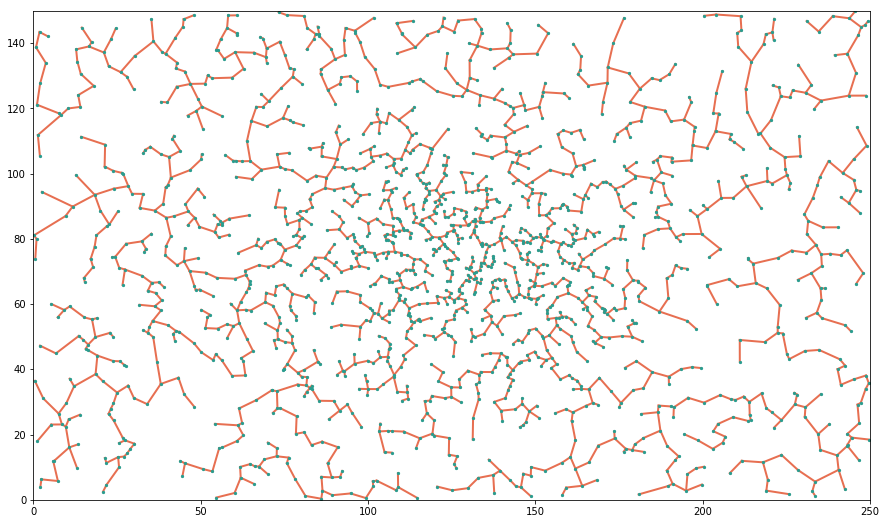

In [11]:
fig, ax = plt.subplots(figsize=(15,9))
X = np.array(coordinates)
# plot all vertices
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
# add all edges for the minimum spanning tree
for w, i, j in mst_edges:
    ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color=red, zorder=1, lw=2)
ax.set_xlim(0,250)
ax.set_ylim(0,150)

### Compute the distance from any vertex on the minimum spanning tree to the closest vertex lying in a park. 

In [12]:
def find_closest_park(vertex, vertices_park, dist_measure):
    '''
    for a given vertex, return the vertex in the park that is the closest to the
    start vertex given a certain distance measure
    '''
    # calculate distances between input vertex and park nodes
    distance_lst = np.array(list(map(lambda i: dist_measure(vertex, i), vertices_park)))
    # return the closestvertex
    return vertices_park[distance_lst.argmin()]

def compute_shortest_path_MST(graph, allparks, dist_measure):
    ''' compute the shortest path between any node in the graph (minimum 
    spanning tree graph) and a park
    '''
    # allocate variables for shortest paths and their lengths
    shortestpaths = []
    shortestpath_length = []
    # loop over all vertices in the MST graph
    for source in graph.keys():
        # find the closest vertex that is in a park
        sink = find_closest_park(source, allparks, dist_measure)
        # calculate the path along the graph from source to sink
        path_astar, length_astar = a_star(graph=graph, source=source, sink=sink,heuristic=dist_measure)
        # store path and path length
        shortestpaths.append(path_astar)
        shortestpath_length.append(length_astar)
    return shortestpaths, shortestpath_length

In [13]:
# Convert to adjacency list representation
graph = edges_to_adj_list(mst_edges)
allparks = park_A + park_B + park_C
# Find shortest path for all vertices
mst_shortest_paths, mst_path_lengths = compute_shortest_path_MST(graph, allparks, euclidean_distance)

In [14]:
# check if the amount of shortest paths is equal to the amount of nodes in the graph
assert len(mst_shortest_paths) == len(graph.keys())

In [15]:
# drop zero distances: the nodes in the park
mst_path_lengths = [i for i in mst_path_lengths if i!=0]

### Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).

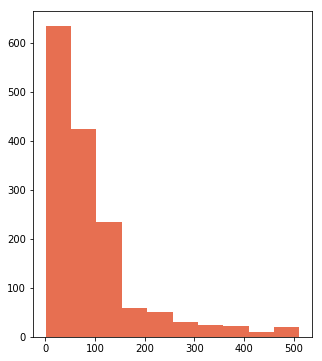

In [16]:
fig, ax = plt.subplots(figsize=(5,6))
ax.hist(mst_path_lengths, color=red);

## Assignment 2: Compute the shortest distances from any vertex to the closest vertex in a park 

### Implement this in an efficient way, not by using A* in a for-loop!

**Step 1: **Get vertices on the edges of the park, the shortest path will always end at the edge of a park (*reducing number of sinks to test*)

In [19]:
def get_vertices_at_edge_park(vertices_park):
    '''
    Returns vertices lying on the edge of the park by looking at the connections to vertices outside the park
    '''
    # edges with only one vertex in the park:
    # edges going in or out of the park
    _filter = [(i[1] in vertices_park) ^ (i[2] in vertices_park) for i in edges]
    # filter list of edges with boolean list
    edges_park = list(itertools.compress(edges, _filter))
    # no distances needed, so remove them
    edges_park_nodistance = [(i[1], i[2]) for i in edges_park]
    # get vertices of the edges going in or out of the park
    vertices_edges_park = np.unique(edges_park_nodistance)
    # slice to have only the vertices inside the park
    return vertices_edges_park[np.isin(vertices_edges_park, vertices_park)]

In [20]:
vertices_edges_park = get_vertices_at_edge_park(park_A + park_B + park_C)

Plotting result, vertices at the edges of the park are bigger

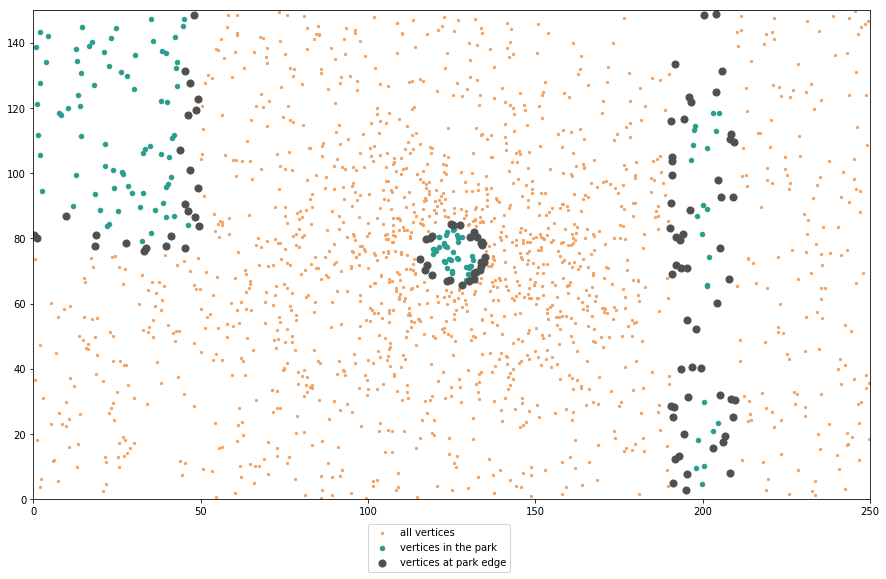

In [21]:
fig, ax = plt.subplots(figsize=(15,9))
X = np.array(coordinates)
# plot vertices
ax.scatter(X[:,0], X[:,1], s=5, color=orange, zorder=2,
           label='all vertices')
# plot vertices of the parks
allparks = park_A + park_B + park_C
ax.scatter(X[allparks,0], X[allparks,1], s=20, color=green, zorder=2,
          label='vertices in the park')
# plot vertices at edge of parks
ax.scatter(X[vertices_edges_park,0], X[vertices_edges_park,1],
           s=50, color=black, zorder=2, label='vertices at park edge')

ax.set_xlim(0,250)
ax.set_ylim(0,150)

plt.legend(bbox_to_anchor=(.4, -.05), loc=2, borderaxespad=0.)

**Step 2:** Loop over all vertices and find the closest path (WIP)

Function definitions

In [22]:
def compute_shortest_path(graph_queu, fullgraph, vertices_edges_park, dist_measure):
    '''
    '''
    # allocate variables for shortest paths and its length, for all the
    # vertices in the collection of paths, and the closest park node for
    # every start vertex
    shortestpaths = []
    shortestpath_length = []
    shortestpath_allvertices = set()
    # while the graph queu is not empty
    while len(list(graph_queu.keys())):
        # source node is the first node of the graph
        source = list(graph_queu.keys())[0]
        # test if source is already in one of the shortest paths
        # if true, the shortest path is already found, so skip calculation
        # and pop this vertex from the graph queue
        if source in shortestpath_allvertices:
            __ = graph_queu.pop(source)
            continue
        else:
            # find the closest vertex at the edge of the park
            sink = find_closest_park(source, vertices_edges_park, dist_measure)
            # calculate the optimal path
            path_astar, length_astar = a_star(graph=fullgraph, source=source, sink=sink,heuristic=dist_measure)
            # store data
            shortestpaths.append(path_astar)
            shortestpath_length.append(length_astar)
            vertices_edges_park=np.append(vertices_edges_park,path_astar[-1])
            for vertex in path_astar:
                shortestpath_allvertices.add(vertex)
            # pop current vertex out of the graph queu
            __ = graph_queu.pop(source)
    return shortestpaths, shortestpath_length

Find shortest path, distance and sinks:

In [24]:
# Convert to adjacency list representation
graph = edges_to_adj_list(edges)
# Remove the vertices that are in a park from the graph queu
graph_noparknodes = graph.copy()
__ = [graph_noparknodes.pop(i) for i in park_A + park_B + park_C]
# Compute the shortest path from each vertex
shortest_unique_paths, path_lengths = \
    compute_shortest_path(graph_noparknodes, graph, vertices_edges_park, euclidean_distance)

postprocess: from the shortest paths, get combinations of vertex, path length, park

get all vertices not in the park

In [25]:
# generate filter: if a vertex from the list of all vertices is in a park
_filter = np.isin(vertices, allparks)
# get the vertices NOT in a mark (note the boolean not on the array)
vertices_not_in_park = list(itertools.compress(vertices, ~_filter))

for each of these vertices get the path that connects that vertex to the closest park

In [26]:
# This will return the index for the first element found or None if no element 
# is found (which will not happen) as every vertex is in a path
# it just needs a path, because if there are multiple matches, the shortest
# path branches upstream, this upstream branching does not have any
# effect of the shortest path, so just the first element suffices
path_idxs = [next((idx 
                   for idx, path 
                   in enumerate(shortest_unique_paths) 
                   if vertex in path),
                  None) # doesn't matter what's here, because every node will be in
                        # in some path
            for vertex in vertices_not_in_park]
# clip shortest path, so that it only contains from source to sink, and not possible previous nodes
shortest_paths = [shortest_unique_paths[path_idx][shortest_unique_paths[path_idx].index(vertex):] 
                  for (path_idx, vertex) in zip(path_idxs, vertices_not_in_park)]
# sanity check: is the first node of all path equal to the list of vertices?
assert np.alltrue([i==j for (i,j) in zip([i[0] for i in shortest_paths], vertices_not_in_park)])
# calculate distances for all these paths


In [27]:
def calc_path_length(path):
    '''calculate the path length for a path (= list of vertice)
    loop over edges in the path: i.e. first and second node are an edge, etc.
    for all these edges, find the occurrence in the edge list of the original
    graph, and get the distance. Finally take the sum of these distances.
    '''
    return sum([next((l
      for (l, start, end)
      in edges
      if ((start==edge_start) & (end==edge_end)) |
         (end==edge_start) & (start==edge_end)), None)
    for edge_start, edge_end in zip(path[:-1], path[1:])])

In [28]:
shortest_paths_lengths = [calc_path_length(path) for path in shortest_paths]

In [29]:
def get_park_from_path(path):
    '''for a given path, get the park where this path ends
    '''
    end_vertex = path[-1]
    if end_vertex in park_C:
        return 'park C'
    elif end_vertex in park_B:
        return 'park B'
    else:
        return 'park A'

In [30]:
source_park = [get_park_from_path(path) for path in shortest_paths]

**Step 3:** Plotting shortest paths

this step is not really necessary? and is covered by other questions

### Show your solution on a plot, color the vertices according to the distances to the closest park and add arrows to indicate which vertex to take.

In [32]:
def plot_path_arrows(path, ax, color=red):
    """
    Plot path on ax
    """
    for i in range(len(path)-1):
        i1, j1 = coordinates[path[i]]
        i2, j2 = coordinates[path[i+1]]
        ax.arrow(i1, j1, i2-i1, j2-j1, shape='full',
                 lw=2, length_includes_head=True, head_width=1.5, color=color)

(0, 150)

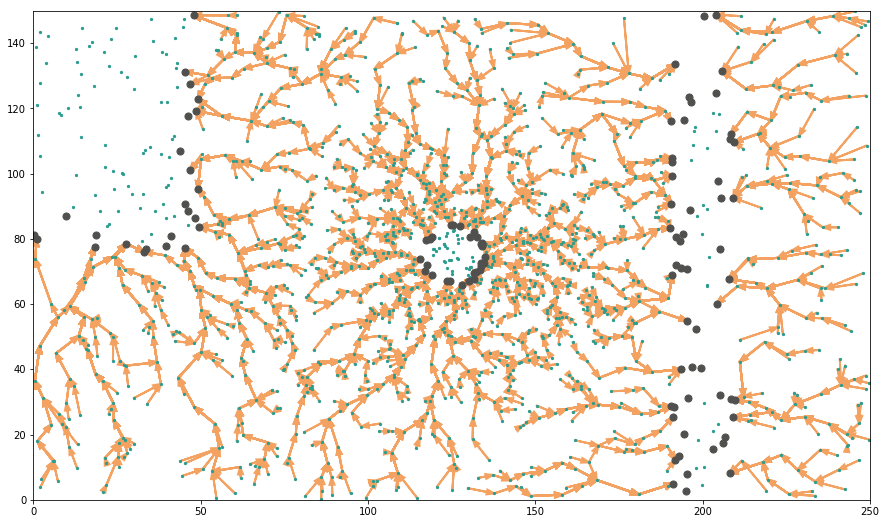

In [33]:
fig, ax = plt.subplots(figsize=(15, 9))
X = np.array(coordinates)
# plot vertices
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
# plot vertices at edge of parks
ax.scatter(X[vertices_edges_park,0], X[vertices_edges_park,1], s=50, color=black, zorder=2)
#for all unique paths, plot the shortest pasts with direction (arrow)
for path_astar in shortest_paths:
    plot_path_arrows(path_astar, ax, orange)
ax.set_xlim(0,250)
ax.set_ylim(0,150)

### Show for every vertex whether park A, B or C is the closest.

In [34]:
def from_idx_to_coord(idxs):
    '''from a list of indices, get two lists of coordinates: xvals and yvals
    '''
    cords = np.array([coordinates[i] for i in idxs])
    xvals, yvals = cords[:,0], cords[:,1]
    return xvals, yvals

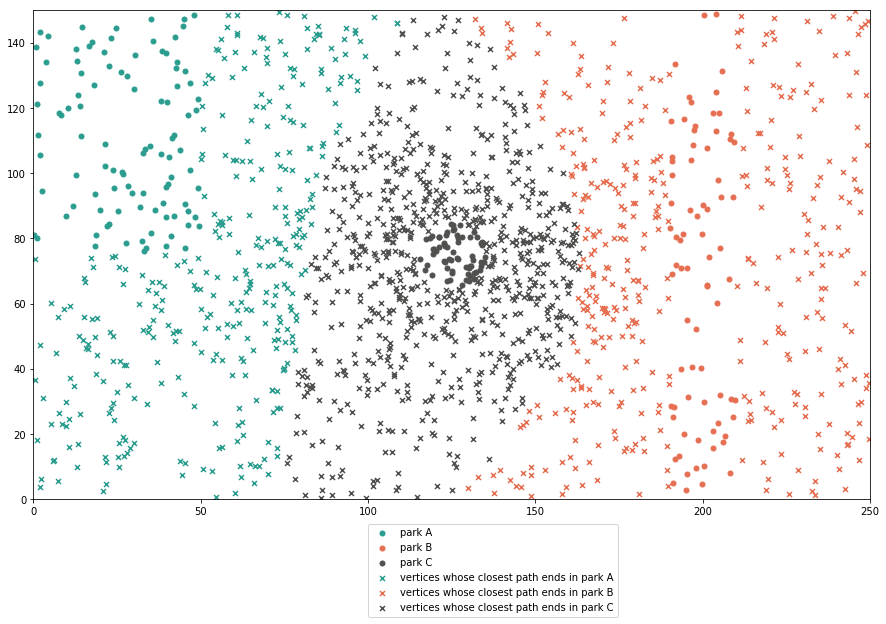

In [35]:
fig, ax = plt.subplots(figsize=(15, 9))
# plot park_A
xvals, yvals = from_idx_to_coord(park_A)
ax.scatter(xvals, yvals, s=25, color=green, zorder=2, label='park A')
# plot park_B
xvals, yvals = from_idx_to_coord(park_B)
ax.scatter(xvals, yvals, s=25, color=red, zorder=2, label='park B')
# plot park_C
xvals, yvals = from_idx_to_coord(park_C)
ax.scatter(xvals, yvals, s=25, color=black, zorder=2, label='park C')
# plot nodes going to park A
vertices_to_park_A = [vertex for (vertex, park) in zip(vertices_not_in_park, source_park) if park=='park A']
xvals, yvals = from_idx_to_coord(vertices_to_park_A)
ax.scatter(xvals, yvals, s=25, color=green, zorder=2, marker='x',
           label='vertices whose closest path ends in park A')
# plot nodes going to park B
vertices_to_park_B = [vertex for (vertex, park) in zip(vertices_not_in_park, source_park) if park=='park B']
xvals, yvals = from_idx_to_coord(vertices_to_park_B)
ax.scatter(xvals, yvals, s=25, color=red, zorder=2, marker='x',
           label='vertices whose closest path ends in park B')
# plot nodes going to park B
vertices_to_park_C = [vertex for (vertex, park) in zip(vertices_not_in_park, source_park) if park=='park C']
xvals, yvals = from_idx_to_coord(vertices_to_park_C)
ax.scatter(xvals, yvals, s=25, color=black, zorder=2, marker='x',
           label='vertices whose closest path ends in park C')
ax.set_xlim(0,250)
ax.set_ylim(0,150)
plt.legend(bbox_to_anchor=(.4, -.05), loc=2, borderaxespad=0.)

### Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).

(array([ 196.,  250.,  295.,  318.,  188.,  117.,   55.,   38.,   37.,   13.]),
 array([  0.74972274,  10.29157066,  19.83341857,  29.37526648,
         38.9171144 ,  48.45896231,  58.00081023,  67.54265814,
         77.08450606,  86.62635397,  96.16820189]),
 <a list of 10 Patch objects>)

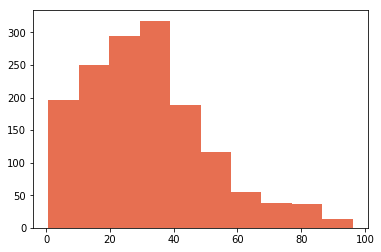

In [36]:
fig, ax = plt.subplots()
ax.hist(shortest_paths_lengths, color=red)

### Compare with the minimum spanning tree.

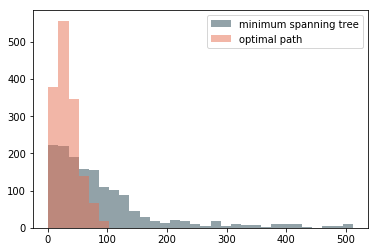

In [37]:
fig, ax = plt.subplots()
ax.hist([shortest_paths_lengths, mst_path_lengths], bins=30, color=[red, blue],
            histtype='stepfilled', alpha=.5,
        label=['optimal path', 'minimum spanning tree'])
ax.legend()
